# Tutorial 快速入门

https://github.com/facebookresearch/faiss/wiki/Faster-search

## This is too slow, how can I make it faster?

To speed up the search, it is possible to segment the dataset into pieces. We define Voronoi cells in the d-dimensional space, and each database vector falls in one of the cells. At search time, only the database vectors y contained in the cell the query x falls in and a few neighboring ones are compared against the query vector.

This is done via the IndexIVFFlat index. This type of index requires a training stage, that can be performed on any collection of vectors that has the same distribution as the database vectors. In this case we just use the database vectors themselves.

The IndexIVFFlat also requires another index, the quantizer, that assigns vectors to Voronoi cells. Each cell is defined by a centroid, and finding the Voronoi cell a vector falls in consists in finding the nearest neighbor of the vector in the set of centroids. This is the task of the other index, which is typically an IndexFlatL2.

There are two parameters to the search method: nlist, the number of cells, and nprobe, the number of cells (out of nlist) that are visited to perform a search. The search time roughly increases linearly with the number of probes plus some constant due to the quantization.

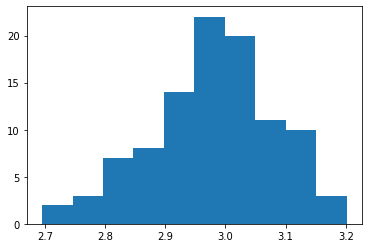

In [1]:
nlist = 100
k = 4
quantizer = faiss.IndexFlatL2(d)  # the other index
index = faiss.IndexIVFFlat(quantizer, d, nlist)
assert not index.is_trained
index.train(xb)
assert index.is_trained

index.add(xb)                  # add may be a bit slower as well
D, I = index.search(xq, k)     # actual search
print(I[-5:])                  # neighbors of the 5 last queries
index.nprobe = 10              # default nprobe is 1, try a few more
D, I = index.search(xq, k)
print(I[-5:])                  # neighbors of the 5 last queries

For nprobe=1, the result looks like

In [ ]:
## 精确索引IndexFlatL2

[[ 9900 10500  9831 10808]
 [11055 10812 11321 10260]
 [11353 10164 10719 11013]
 [10571 10203 10793 10952]
 [ 9582 10304  9622  9229]]

The values are similar, but not exactly the same as for the brute-force search (see above). This is because some of the results were not in the exact same Voronoi cell. Therefore, visiting a few more cells may prove useful.

Increasing nprobe to 10 does exactly this:

```
[[ 9900 10500  9309  9831]
 [11055 10895 10812 11321]
 [11353 11103 10164  9787]
 [10571 10664 10632  9638]
 [ 9628  9554 10036  9582]]
```

which is the correct result. Note that getting a perfect result in this case is merely an artifact of the data distribution, as it is has a strong component on the x-axis which makes it easier to handle. The nprobe parameter is always a way of adjusting the tradeoff between speed and accuracy of the result. Setting nprobe = nlist gives the same result as the brute-force search (but slower).